# Example Ordering

In this example notebook, we will compare the performance of the operations of the Example Operations notebook with and without spatial ordering.


We will first load the example STM, order it according to the Morton code of the pixel coordinates and store and reload it. 
This will provide a fair comparison of delayed operations.

For many operations, spatial ordering becomes beneficial when the chuck size is small relative to the data size. 
We will simulate this by creating duplicate STMs with a chunk size that is a lot smaller than normally recommended.


We will then show the change in the order of the elements by plotting how they are chunked.
We provide two examples:
1. The chunks are large relative to the complete dataset. Several of the ordered chunks cover a large part of the spatial extent.
2. The chunks are small relative to the complete dataset. These ordered chunks are much more spatially coherent than the original chunks.

Note that in the first example, reordering will likely not improve operation efficiency.


Finally, we will apply the subset operations of the Example Operations notebook on each dataset and compare their processing times.

## Prepare the data

For setup and, see [Example Operations notebook](./demo_operations_stm.ipynb)

To preform a fair comparison with re-chunked and ordered datasets, we will store and reload the data after re-chunking and ordering.

In [1]:
from pathlib import Path
import xarray as xr
import numpy as np
import os
import stmtools

In [2]:
# Note that normally we would advise using a chuck size closer to 10000.
# This chunk size is chosen to demonstrate the potential advantages of spatial sorting for larger datasets.
path_stm = Path('./stm.zarr')
chunksize = 500

path_stm_ordered = Path(f'./stm_ordered.zarr')

In [3]:
# Start a Dask client.
# Note that this is not necessary when not debugging the Dask operations
# and that this client can make saving the ordered STM a lot slower.
# from dask.distributed import Client
# client = Client()

In [4]:
# Load original Zarr.
stmat = xr.open_zarr(path_stm)
stmat = stmat.chunk({'space': 10000, 'time': -1})
stmat

<xarray.Dataset> Size: 14MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [5]:
if not os.path.isdir(path_stm_ordered):
    # Reorder a copy of the STM.
    print("ordering...")
    stmat_ordered = stmat.copy()
    stmat_ordered = stmat_ordered.stm.reorder(xlabel="azimuth", ylabel="range")
    
    # Save to Zarr.
    # effect of encoding: https://github.com/pydata/xarray/issues/7686
    stmat_ordered = stmat_ordered.reset_encoding()
    stmat_ordered.to_zarr(path_stm_ordered, mode='w')

# Load ordered Zarr.
stmat_ordered = xr.open_zarr(path_stm_ordered)
stmat_ordered

<xarray.Dataset> Size: 15MB
Dimensions:    (space: 78582, time: 10)
Coordinates:
    azimuth    (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lat        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    lon        (space) float32 314kB dask.array<chunksize=(10000,), meta=np.ndarray>
    range      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    complex    (space, time) complex64 6MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
    order      (space) int64 629kB dask.array<chunksize=(10000,), meta=np.ndarray>
    phase      (space, time) float32 3MB dask.array<chunksize=(10000, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [6]:
# Make STM with smaller chunks.
stmat_chunked = stmat.copy().chunk({'space': chunksize, 'time': -1})
stmat_chunked = stmat_chunked.isel(space=slice(24000, 48000))
stmat_chunked

<xarray.Dataset> Size: 4MB
Dimensions:    (space: 24000, time: 10)
Coordinates:
    azimuth    (space) int64 192kB dask.array<chunksize=(500,), meta=np.ndarray>
    lat        (space) float32 96kB dask.array<chunksize=(500,), meta=np.ndarray>
    lon        (space) float32 96kB dask.array<chunksize=(500,), meta=np.ndarray>
    range      (space) int64 192kB dask.array<chunksize=(500,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 960kB dask.array<chunksize=(500, 10), meta=np.ndarray>
    complex    (space, time) complex64 2MB dask.array<chunksize=(500, 10), meta=np.ndarray>
    phase      (space, time) float32 960kB dask.array<chunksize=(500, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

In [7]:
# Make ordered STM with smaller chunks.
stmat_ordered_chunked = stmat_ordered.copy().chunk({'space': chunksize, 'time': -1})
stmat_ordered_chunked = stmat_ordered_chunked.isel(space=slice(24000, 48000))
stmat_ordered_chunked

<xarray.Dataset> Size: 5MB
Dimensions:    (space: 24000, time: 10)
Coordinates:
    azimuth    (space) int64 192kB dask.array<chunksize=(500,), meta=np.ndarray>
    lat        (space) float32 96kB dask.array<chunksize=(500,), meta=np.ndarray>
    lon        (space) float32 96kB dask.array<chunksize=(500,), meta=np.ndarray>
    range      (space) int64 192kB dask.array<chunksize=(500,), meta=np.ndarray>
  * time       (time) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: space
Data variables:
    amplitude  (space, time) float32 960kB dask.array<chunksize=(500, 10), meta=np.ndarray>
    complex    (space, time) complex64 2MB dask.array<chunksize=(500, 10), meta=np.ndarray>
    order      (space) int64 192kB dask.array<chunksize=(500,), meta=np.ndarray>
    phase      (space, time) float32 960kB dask.array<chunksize=(500, 10), meta=np.ndarray>
Attributes:
    multi-look:  coarsen-mean

### Visualize the results

The images below are colored by chunk.

In [8]:
from matplotlib import pyplot as plt
import matplotlib.cm as cm

In [9]:
def plot_stmats(stmat_0, stmat_1):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    colors = cm.rainbow(np.linspace(0, 1, len(stmat_0.chunks["space"])))
    
    start_idx = 0
    for color, chunk in zip(colors, stmat_0.chunks["space"]):
        space = slice(start_idx, start_idx+chunk)
        scatter_0 = stmat_0.isel(space=space)
        scatter_1 = stmat_1.isel(space=space)
        axs[0].scatter(scatter_0['lon'], scatter_0['lat'], s=1, color=color)
        axs[1].scatter(scatter_1['lon'], scatter_1['lat'], s=1, color=color)
        start_idx += chunk

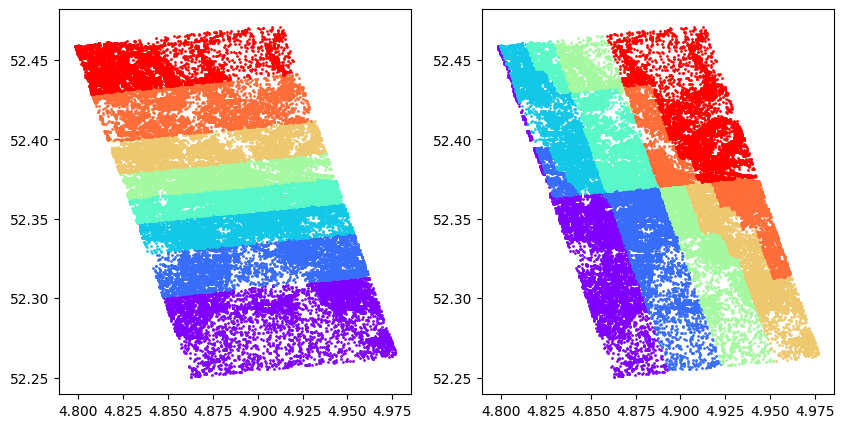

In [10]:
# Visualize big chunks before and after reordering.
plot_stmats(stmat, stmat_ordered)

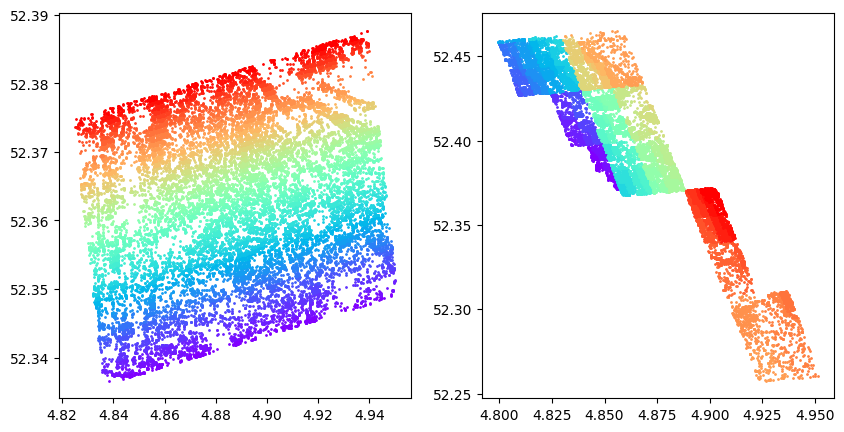

In [11]:
# Visualize small chunks before and after reordering.
plot_stmats(stmat_chunked, stmat_ordered_chunked)

## Apply subset operation

These operations are applied to both the original STMs and the ordered STMs and timed.

Note that the profiling can take some time.

In [12]:
path_polygon = Path('bag_light_AMS_WGS84.gpkg')

In [23]:
# Time the reordering operation.
time_ordering = %timeit -o stmat.copy().stm.reorder(xlabel="azimuth", ylabel="range")
time_ordering

/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 230 times more chunks
  return self.array[key]
/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 230 times more chunks
  return self.array[key]
/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 230 times more chunks
  return self.array[key]
/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 230 times more chunks
  return self.array[key]
/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order in

375 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/storage/miniforge3/envs/mbl_stmtools/lib/python3.11/site-packages/xarray/core/indexing.py:1430: PerformanceWarning: Slicing with an out-of-order index is generating 230 times more chunks
  return self.array[key]


<TimeitResult : 375 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [24]:
%%timeit -o
# Time subset operation on original STM.
stmat_subset = stmat.stm.subset(method='polygon', polygon=path_polygon)
phase = stmat_subset['phase'].compute()

/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storag

53.9 s ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 53.9 s ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [25]:
time_subset = _
time_subset

<TimeitResult : 53.9 s ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [26]:
%%timeit -o
# Time subset operation on ordered STM.
stmat_ordered_subset = stmat_ordered.stm.subset(method='polygon', polygon=path_polygon)
phase = stmat_ordered_subset['phase'].compute()

/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storag

2min 7s ± 883 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 7s ± 883 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [27]:
time_subset_ordered = _
time_subset_ordered

<TimeitResult : 2min 7s ± 883 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [28]:
%%timeit -o
# Time subset operation on chunked STM.
stmat_chunked_subset = stmat_chunked.stm.subset(method='polygon', polygon=path_polygon)
phase = stmat_chunked_subset['phase'].compute()

/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storag

2min 51s ± 476 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2min 51s ± 476 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [29]:
time_subset_chunked = _
time_subset_chunked

<TimeitResult : 2min 51s ± 476 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [30]:
%%timeit -o
# Time subset operation on ordered chunked STM.
stmat_ordered_chunked_subset = stmat_ordered_chunked.stm.subset(method='polygon', polygon=path_polygon)
phase = stmat_ordered_chunked_subset['phase'].compute()

/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storage/MobyLe/stmtools/stmtools/stm.py:134: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if dim not in self._obj.dims.keys():
/storag

1min 4s ± 316 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 4s ± 316 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [31]:
stmat_ordered_chunked_chunked = _
stmat_ordered_chunked_chunked

<TimeitResult : 1min 4s ± 316 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [32]:
print(f"Ordering:                  {time_ordering}")
print(f"Subset (original):         {time_subset}")
print(f"Subset (ordered):          {time_subset_ordered}")
print("")
print(f"Subset (chunked):          {time_subset_chunked}")
print(f"Subset (chunked, ordered): {stmat_ordered_chunked_chunked}")

Ordering:                  375 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Subset (original):         53.9 s ± 1.5 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Subset (ordered):          2min 7s ± 883 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Subset (chunked):          2min 51s ± 476 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Subset (chunked, ordered): 1min 4s ± 316 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
